<a href="https://colab.research.google.com/github/tanishkaa31/Denoising-Speech/blob/main/DAE_Audio_0_004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
!unzip \archive.zip -d \content\data

Archive:  archive.zip
  inflating: contentdata/free-spoken-digit-dataset-master/.gitignore  
  inflating: contentdata/free-spoken-digit-dataset-master/README.md  
  inflating: contentdata/free-spoken-digit-dataset-master/__init__.py  
  inflating: contentdata/free-spoken-digit-dataset-master/acquire_data/say_numbers_prompt.py  
  inflating: contentdata/free-spoken-digit-dataset-master/acquire_data/split_and_label_numbers.py  
  inflating: contentdata/free-spoken-digit-dataset-master/metadata.py  
  inflating: contentdata/free-spoken-digit-dataset-master/pip_requirements.txt  
  inflating: contentdata/free-spoken-digit-dataset-master/recordings/0_george_0.wav  
  inflating: contentdata/free-spoken-digit-dataset-master/recordings/0_george_1.wav  
  inflating: contentdata/free-spoken-digit-dataset-master/recordings/0_george_10.wav  
  inflating: contentdata/free-spoken-digit-dataset-master/recordings/0_george_11.wav  
  inflating: contentdata/free-spoken-digit-dataset-master/recordings/0_

In [ ]:
import os
os.listdir('/content/contentdata/free-spoken-digit-dataset-master/recordings')

['5_lucas_32.wav',
 '9_george_19.wav',
 '0_lucas_29.wav',
 '2_nicolas_27.wav',
 '1_lucas_25.wav',
 '8_theo_32.wav',
 '0_yweweler_31.wav',
 '4_jackson_9.wav',
 '6_nicolas_11.wav',
 '4_george_30.wav',
 '2_yweweler_34.wav',
 '2_yweweler_1.wav',
 '7_theo_44.wav',
 '5_lucas_12.wav',
 '1_nicolas_46.wav',
 '3_george_42.wav',
 '4_lucas_45.wav',
 '1_nicolas_47.wav',
 '9_yweweler_28.wav',
 '1_yweweler_32.wav',
 '3_george_7.wav',
 '2_lucas_27.wav',
 '1_george_49.wav',
 '0_george_46.wav',
 '7_nicolas_38.wav',
 '7_theo_15.wav',
 '0_jackson_16.wav',
 '8_yweweler_24.wav',
 '3_lucas_31.wav',
 '5_lucas_26.wav',
 '0_nicolas_11.wav',
 '5_nicolas_37.wav',
 '7_george_17.wav',
 '8_nicolas_46.wav',
 '9_lucas_28.wav',
 '7_theo_22.wav',
 '4_nicolas_10.wav',
 '9_george_12.wav',
 '9_yweweler_23.wav',
 '0_nicolas_45.wav',
 '8_jackson_48.wav',
 '5_theo_30.wav',
 '8_jackson_35.wav',
 '9_jackson_19.wav',
 '1_yweweler_20.wav',
 '4_yweweler_5.wav',
 '6_jackson_33.wav',
 '8_theo_48.wav',
 '5_lucas_49.wav',
 '7_lucas_7.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import soundfile as sf
import IPython
from scipy.io.wavfile import read
import librosa.display

In [ ]:
train = []
for i in os.listdir('/content/contentdata/free-spoken-digit-dataset-master/recordings'):
  a, _ = sf.read("/content/contentdata/free-spoken-digit-dataset-master/recordings/" + i)
  train.append(a)

In [ ]:
size = 0
for i in range(len(train)):
  size += train[i].shape[0]

In [ ]:
mean_size = size/len(train)
mean_size

3499.4746666666665

In [ ]:
def make_same(data):
  temp = []
  for i in data:
    if i.shape[0]>mean_size:
      i = i[:3500]
    else:
      while i.shape[0] < 3500:
        i = np.append(i,0)
    temp.append(i)
  return temp

In [ ]:
train = make_same(train)
train_data = train[:2100]
test_data = train[2100:]

In [ ]:
train_data[50].shape

(3500, 1)

In [ ]:
test_data[0].shape

(3500,)

## Prepare the data

In [ ]:
def process(data):
  temp_data = []
  noise_factor = 0.004

  for i in data:
    temp = i + noise_factor*np.random.normal(size=i.shape)
    temp_data.append(temp)
  return temp_data

In [ ]:
# Create a copy of the data with added noise
noisy_train_data = process(train_data)
noisy_test_data = process(test_data)

## Comparing Noisy Data and Original Data

In [ ]:
sf.write('noisy_train_0.wav', noisy_train_data[0], 8000)
noisy_train_data[0]

array([[-0.00045294],
       [-0.00338641],
       [ 0.00018753],
       ...,
       [ 0.02171917],
       [ 0.02701281],
       [ 0.02403335]])

In [ ]:
sf.write('train_0.wav', train_data[0], 8000)
train_data[0] 

array([[0.00085449],
       [0.00048828],
       [0.00036621],
       ...,
       [0.02651978],
       [0.02679443],
       [0.03057861]])

## Build the autoencoder

I have used the Functional API to build a denoising convolutional autoencoder.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [ ]:
input = layers.Input(shape=(3500,1,))

# Encoder
x = layers.Conv1D(32, 3, activation="relu", padding="same")(input)
x = layers.MaxPooling1D(3,strides =  2,padding="same")(x)
x = layers.Conv1D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling1D(3,strides = 2, padding="same")(x)

# Decoder
x = layers.Conv1DTranspose(64,3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv1DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv1DTranspose(32, 3, activation="relu", padding="same")(x)
x = layers.Conv1D(1, 3, activation="tanh", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3500, 1)]         0         
                                                                 
 conv1d_9 (Conv1D)           (None, 3500, 32)          128       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 1750, 32)         0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 1750, 64)          6208      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 875, 64)          0         
 1D)                                                             
                                                                 
 conv1d_transpose_9 (Conv1DT  (None, 1750, 64)         1235

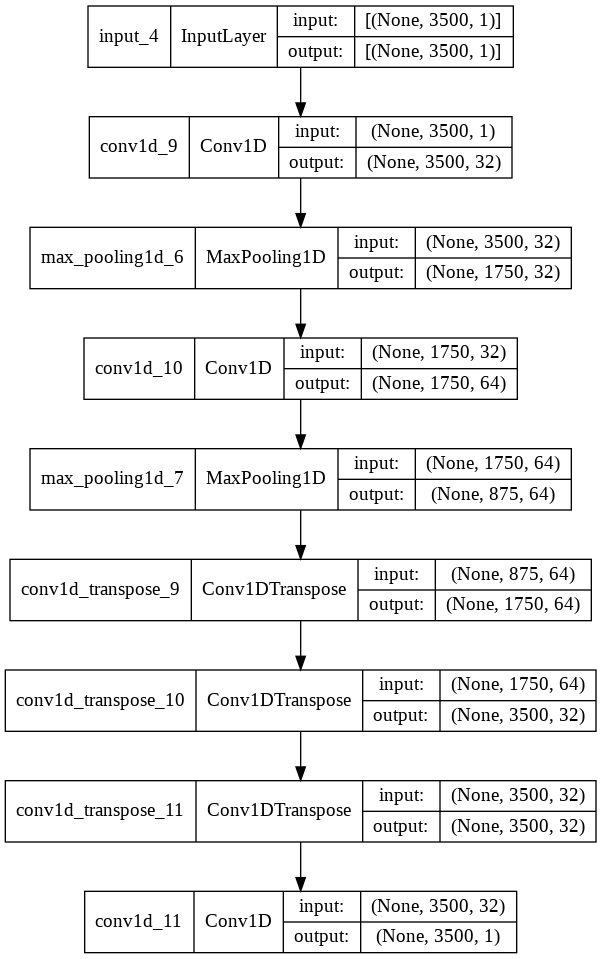

In [ ]:
keras.utils.plot_model(autoencoder, show_shapes=True)

## Predictions

In [ ]:
def model_ready(x):
  x = np.array(x)
  x = np.reshape(x, (x.shape[0], x.shape[1], 1))
  return x

In [ ]:
noisy_test_data = model_ready(noisy_test_data)
noisy_train_data = model_ready(noisy_train_data)
test_data = model_ready(test_data)
train_data = model_ready(train_data)

In [ ]:
noisy_test_data.shape

(900, 3500, 1)

In [ ]:
train_data.shape

(2100, 3500, 1)

In [ ]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/30
17/17 [==============================] - 29s 2s/step - loss: 8.4281e-04 - val_loss: 6.1418e-04
Epoch 2/30
17/17 [==============================] - 28s 2s/step - loss: 5.5333e-04 - val_loss: 5.0793e-04
Epoch 3/30
17/17 [==============================] - 28s 2s/step - loss: 4.8672e-04 - val_loss: 4.5758e-04
Epoch 4/30
17/17 [==============================] - 28s 2s/step - loss: 4.3954e-04 - val_loss: 4.1307e-04
Epoch 5/30
17/17 [==============================] - 28s 2s/step - loss: 3.9822e-04 - val_loss: 3.7386e-04
Epoch 6/30
17/17 [==============================] - 29s 2s/step - loss: 3.6825e-04 - val_loss: 3.3788e-04
Epoch 7/30
17/17 [==============================] - 28s 2s/step - loss: 3.2903e-04 - val_loss: 3.0689e-04
Epoch 8/30
17/17 [==============================] - 28s 2s/step - loss: 2.9595e-04 - val_loss: 2.8109e-04
Epoch 9/30
17/17 [==============================] - 28s 2s/step - loss: 2.7100e-04 - val_loss: 2.5836e-04
Epoch 10/30
17/17 [===========================

Let's now predict on the noisy data and display the results of our autoencoder.

In [ ]:
prediction = autoencoder.predict(noisy_test_data)

In [ ]:
prediction

array([[[-0.0023393 ],
        [ 0.00632936],
        [ 0.00254576],
        ...,
        [-0.00195955],
        [-0.02315916],
        [-0.01429761]],

       [[-0.00379237],
        [ 0.01038449],
        [ 0.00593865],
        ...,
        [ 0.00525704],
        [-0.01688376],
        [-0.01087116]],

       [[-0.01526729],
        [ 0.0071919 ],
        [ 0.00515965],
        ...,
        [ 0.00013779],
        [-0.02009129],
        [-0.01265511]],

       ...,

       [[-0.00281601],
        [ 0.00974603],
        [ 0.00645939],
        ...,
        [-0.00059025],
        [-0.0211974 ],
        [-0.01314261]],

       [[-0.00361395],
        [ 0.00759939],
        [ 0.00644118],
        ...,
        [ 0.00246572],
        [-0.01758738],
        [-0.01151082]],

       [[-0.0024117 ],
        [ 0.01018332],
        [ 0.00594432],
        ...,
        [-0.00147507],
        [-0.02439296],
        [-0.0124965 ]]], dtype=float32)

## Denoising

In [ ]:
sf.write('noisy_test1.wav', noisy_test_data[0], 8000)
sf.write('pred_test1.wav', prediction[0], 8000)
sf.write('noisy_test2.wav', noisy_test_data[20], 8000)
sf.write('pred_test2.wav', prediction[20], 8000)

In [ ]:
IPython.display.Audio('noisy_test2.wav')

In [ ]:
IPython.display.Audio('pred_test2.wav')

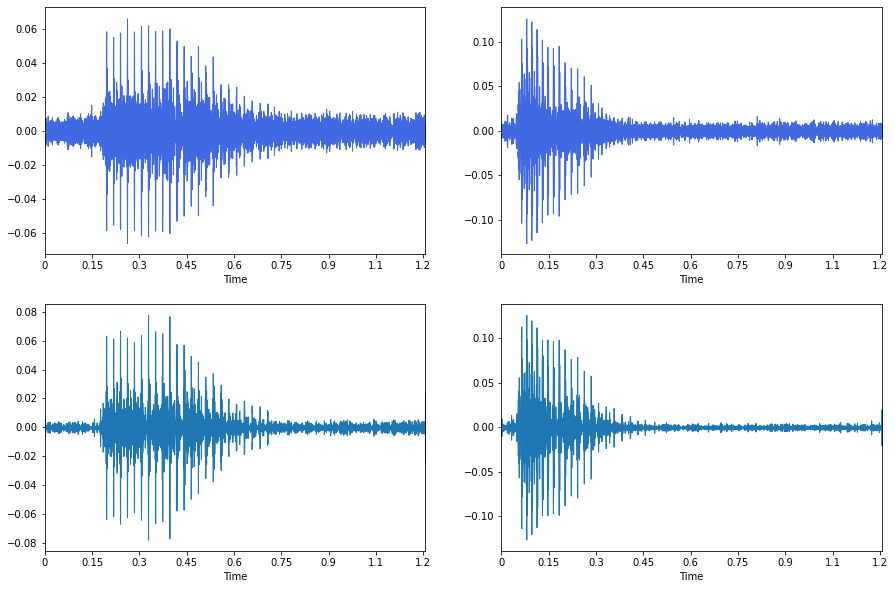

In [ ]:
plt.figure(figsize=(15,10))
array = ["noisy_test1.wav", "noisy_test2.wav", "pred_test1.wav", "pred_test2.wav"]
for i in range(2):
    plt.subplot(2, 2, i + 1)
    j = librosa.load(array[i])
    librosa.display.waveplot(j[0], sr=8000, color = 'royalblue')
  
for i in range(2,4):
    plt.subplot(2, 2, i + 1)
    j = librosa.load(array[i])
    librosa.display.waveplot(j[0], sr=8000)

In [ ]:
autoencoder.save('/content/autoencoder_model.h5')

In [ ]:
from keras.models import load_model
model = load_model('/content/autoencoder_model.h5')